In [29]:


import pyro
import torch
import pyro.distributions as dist
from pyro.optim import Adam
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

     |████████████████████████████████| 804.1 MB 4.2 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Uninstalling torch-1.9.0:
      Successfully uninstalled torch-1.9.0
     |████████████████████████████████| 495 kB 6.8 MB/s 
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached pyro_api-0.1.2-py3-none-any.whl (11 kB)


In [30]:
dataset = datasets.load_wine()
features = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
predictors = dataset['feature_names'][:5]
df = features[["alcohol","malic_acid","ash","magnesium","total_phenols"]]
# normalization
df = (df-df.min())/(df.max()-df.min())
df.head()

,alcohol,malic_acid,ash,magnesium,total_phenols
0,0.842105,0.191700,0.572193,0.619565,0.627586
1,0.571053,0.205534,0.417112,0.326087,0.575862
2,0.560526,0.320158,0.700535,0.336957,0.627586
3,0.878947,0.239130,0.609626,0.467391,0.989655
4,0.581579,0.365613,0.807487,0.521739,0.627586


In [11]:
predictors

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium']

In [31]:
features = torch.stack([torch.tensor(df[colname].values) for colname in df], dim=1)
# train-test splitting
x_train, x_test, y_train, y_test = train_test_split(features, dataset.target, test_size=0.2, random_state=0)
x_train = torch.tensor(x_train)
x_test = torch.tensor(x_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

### 1

In [42]:
pyro.clear_param_store()

def model(x, yobs):
    n_observations, n_predictors = x.shape

    w1 = pyro.sample("w1", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)).independent(1))
    b1 = pyro.sample("b1", dist.Normal(0.,1.))

    w2 = pyro.sample("w2", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)).independent(1))
    b2 = pyro.sample("b2", dist.Normal(0.,1.))

    # non-linearity
    yhat0 = torch.zeros(n_observations, dtype=torch.float)
    yhat1 = (w1*x).sum(dim=1) + b1
    yhat2 = (w2*x).sum(dim=1) + b2

    # apply softmax to normalize to a prob distro
    softmax = torch.nn.Softmax(dim=1)
    yhat = softmax(torch.stack([yhat0,yhat1,yhat2], dim=1))

    with pyro.plate("data", n_observations):
        # sampling 0-1 labels from Bernoulli distribution
        y = pyro.sample("y", dist.Categorical(probs=yhat), obs=yobs)

In [41]:
def guide(x, y=None):
    n_observations, n_predictors = x.shape

    w1_loc = pyro.param("w1_loc", torch.rand(n_predictors))
    w1_scale = pyro.param("w1_scale", torch.rand(n_predictors), constraint=constraints.positive)

    w1 = pyro.sample("w1", dist.Normal(w1_loc, w1_scale).independent(1))

    w2_loc = pyro.param("w2_loc", torch.rand(n_predictors))
    w2_scale = pyro.param("w2_scale", torch.rand(n_predictors), constraint=constraints.positive)

    w2 = pyro.sample("w2", dist.Normal(w2_loc, w2_scale).independent(1))

    b1_loc = pyro.param("b1_loc", torch.rand(1))
    b1_scale = pyro.param("b1_scale", torch.rand(1), constraint=constraints.positive)

    b1 = pyro.sample("b1", dist.Normal(b1_loc, b1_scale))

    b2_loc = pyro.param("b2_loc", torch.rand(1))
    b2_scale = pyro.param("b2_scale", torch.rand(1), constraint=constraints.positive)

    b2 = pyro.sample("b2", dist.Normal(b2_loc, b2_scale))

### 2

Step 0 : loss = 1.3411409032840056
Step 1000 : loss = 0.9809547056882731
Step 2000 : loss = 0.8370438943325877
Step 3000 : loss = 0.8401696386287846
Step 4000 : loss = 0.8406880215290733
Step 5000 : loss = 0.8419072701285025
Step 6000 : loss = 0.8477631458188198
Step 7000 : loss = 0.8158678019635676
Step 8000 : loss = 0.8162644202058382
Step 9000 : loss = 0.8582297791602896


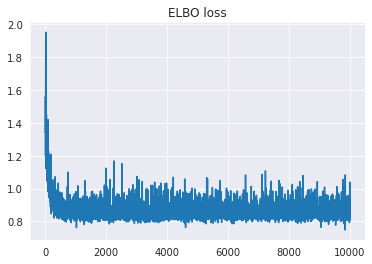

In [43]:
log_reg_svi = SVI(model=model, guide=guide, optim=optim.Adam({'lr' : 0.02}), loss=Trace_ELBO()) 

losses = []
for step in range(10000):
    loss = log_reg_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")

plt.title("ELBO loss")
plt.plot(losses)

In [44]:
w1 = pyro.get_param_store()["w1_loc"]
b1 = pyro.get_param_store()["b1_loc"]
w2 = pyro.get_param_store()["w2_loc"]
b2 = pyro.get_param_store()["b2_loc"]

def predict_class(x):

    y0 = torch.zeros(x.shape[0], dtype=torch.float)
    y1 = (w1*x).sum(dim=1) + b1
    y2 = (w2*x).sum(dim=1) + b2

    softmax = torch.nn.Softmax(dim=1)
    out = softmax(torch.stack([y0,y1,y2], dim=1))
    out = torch.argmax(out, dim=1)

    return out

In [45]:
correct_predictions = (predict_class(x_test) == y_test).sum().item()

print("accuracy: ", correct_predictions/len(x_test))

accuracy:  0.8888888888888888


In [46]:
for i in range(3):
    correct_predictions_i = ((predict_class(x_test) == y_test) & (predict_class(x_test) == i)).sum().item()
    accur_i = correct_predictions_i/(y_test == i).sum().item()
    print("test acc for wine {}: ".format(i), accur_i)

test acc for wine 0:  0.8571428571428571
test acc for wine 1:  0.9375
test acc for wine 2:  0.8333333333333334
